<a href="https://colab.research.google.com/github/diegobnh/odroid_xu4_v2/blob/master/Selecting_PerformanceCounters_ARM32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting Performance Monitoring Counter (pmc) on ARM Architecture


# Problem

---



One way to analyze the application's performance is to collect data from registers contained within the processor. Almost all CPU has a fixed number of registers which can be used to monitor application performance. These registers we will call Performance Monitoring Counter (PMC). The board analyzed in this experiment is called Odroid XU4. This board also has two CPU types: A7 (little core) and A15 (big core) with a maximum number of pmc per core of 4 and 6, respectively. Given a wide option of information that can be collected from the arm 32 architecture, only 4 for little and 6 for big can be collected at a time. The challenge is to know which information to collect that most contributes to explain the execution time.


# PMCs on Odroid

---

In little core only four pmc can be collected. In big core only six pmc can be collected. In total, 33 pmcs in little and 56 pmcs in big were analyzed as shown below:


Little core: *inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA.*

Big core: *L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,BR_MIS_PRED:0x10,BR_PRED:0x12,MEM_ACCESS:0x13,L1I_CACHE_ACCESS:0x14,L1D_CACHE_WB:0x15,L2D_CACHE_ACCESS:0x16,L2D_CACHE_REFILL:0x17,L2D_CACHE_WB:0x18,BUS_ACCESS:0x19,INST_SPEC:0x1B,BUS_CYCLES:0x1D,L1D_CACHE_LD:0x40,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E*

# Applications

---



We chose bots for being a suite that makes use of the openmp. In addition, in bots you can see applications that have the best performance in the three configurations analyzed. Some suites is hard to find applications that perform better, for example, in the smallest configuration analyzed, in this case 4 little. These are the bot applications:


*   FFT: Computes a Fast Fourier Transformation.
*   Fib: Computes the nth fibonacci number using a recursive paralellization.
*   Floorplan: Computes the optimal placement of cells in a floorplan.
*   Health: Simulates a country health system.
*   NQueens: Finds solutions of the N Queens problem.
*   Sort: Uses a mixture of sorting algorithms to sort a vector.
*   SparseLU: Computes the LU factorization of a sparse matrix.
*   Strassen: Computes a matrix multiply with Strassen's method.



In [0]:
from google.colab import drive 
drive.mount('/mntDrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mntDrive


# Explore the Data

---

After collecting all performance counters(33 in little and 56 in big), a dataset was created containing the average of each performance counter for each application.

Three different types of configurations were analyzed: 4b4l (all cores enabled), 4b (four big cores enabled) and 4l (four little cores enabled). Although the configuration space is small they are quite representative.

We model our problem as Multi Target Regression. So, the last 3 columns represent the speedup of time in 4l, 4b and 4b4l configuration. Speedup is calculated by dividing the runtime in one configuration by another. Values greater than 1 indicate that the configuration has a shorter execution time. The higher the value, the shorter the runtime. Values less than 1 indicate a longer execution time.

<img src="http://drive.google.com/uc?export=view&id=1xihH1i1vpl_EgrTMFZhb5A7vdbGhBmGC">

### Data collected from 4l config

In [0]:
path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv"
df = pd.read_csv(path)

df.head(8)

,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA,speedup4l,speedup4b,speedup4b4l
0,0.000716,5.393571e-05,0.005535,0.116889,0.000961,0.077897,0.023961,0.414214,0.000003,0.000003,0.040932,0.076223,0.001882,0.001490,0.006591,0.070949,0.117177,0.230069,0.002461,0.009404,0.001142,0.000211,0.009517,0.250001,0.006101,0.003653,0.008926,0.000806,4.285714e-08,0.007172,0.005148,0.009015,0.003078,1,0.974523,0.494156
1,0.003307,3.014286e-05,0.004371,0.167428,0.000428,0.100081,0.040155,0.432305,0.000412,0.000412,0.044850,0.081749,0.004362,0.001997,0.012226,0.071011,0.162272,0.293367,0.000214,0.009932,0.000019,0.000007,0.007948,0.250054,0.002359,0.006137,0.009259,0.003347,0.000000e+00,0.000640,0.004480,0.005356,0.005797,1,1.003448,0.433184
2,0.001089,2.623494e-06,0.003502,0.434471,0.000026,0.207505,0.182349,0.567200,0.000109,0.000109,0.028346,0.047574,0.002294,0.002905,0.006153,0.042736,0.427060,0.338646,0.003348,0.012155,0.000263,0.003083,0.015938,0.249994,0.002264,0.016037,0.012965,0.001129,1.452771e-04,0.589795,0.001654,0.150489,0.000441,1,2.077785,1.289714
3,0.000297,7.391304e-06,0.004481,0.093421,0.000073,0.055662,0.025300,0.277840,0.000004,0.000004,0.025847,0.041273,0.001908,0.000405,0.003050,0.037999,0.093591,0.160829,0.002997,0.007788,0.002233,0.002045,0.019211,0.250000,0.010189,0.009032,0.007823,0.000355,0.000000e+00,0.006861,0.001531,0.003657,0.001486,1,1.251237,0.789967
4,0.001759,7.884211e-06,0.004174,0.170126,0.000161,0.110293,0.037861,0.622169,0.000203,0.000203,0.061406,0.143258,0.003450,0.001354,0.013467,0.132634,0.170173,0.373689,0.000135,0.006088,0.000010,0.000006,0.005310,0.250011,0.001839,0.003483,0.005953,0.001526,0.000000e+00,0.000270,0.003317,0.005381,0.003992,1,0.932477,0.507174
5,0.000322,3.658960e-06,0.004420,0.042430,0.001671,0.019601,0.018367,0.220219,0.000008,0.000008,0.029917,0.039931,0.003525,0.000142,0.007076,0.034563,0.042848,0.140082,0.004413,0.009281,0.003388,0.002044,0.022509,0.250000,0.013898,0.008870,0.009458,0.000381,9.653179e-07,0.030250,0.011556,0.012683,0.000019,1,1.738158,1.869762
6,0.000075,9.128440e-07,0.003437,0.246938,0.000006,0.165763,0.081080,0.580321,0.000001,0.000001,0.081399,0.082811,0.000050,0.000028,0.000979,0.082670,0.246845,0.260306,0.003442,0.007015,0.000144,0.000059,0.000818,0.250000,0.000583,0.000238,0.007018,0.000128,0.000000e+00,0.003608,0.002509,0.000121,0.000004,1,2.834962,3.620718
7,0.000164,3.287823e-06,0.005418,0.159371,0.002423,0.132459,0.024853,0.331228,0.000009,0.000009,0.014868,0.018477,0.000864,0.000822,0.000728,0.016774,0.158802,0.177296,0.005316,0.010904,0.001803,0.000914,0.011764,0.250001,0.008026,0.003728,0.011126,0.000232,4.944649e-07,0.132542,0.007970,0.009611,0.000004,1,1.986178,2.473063


### Data collected from 4b config


In [0]:
path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv"
df = pd.read_csv(path)

df.head(8)

,L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,BR_MIS_PRED:0x10,BR_PRED:0x12,MEM_ACCESS:0x13,L1I_CACHE_ACCESS:0x14,L1D_CACHE_WB:0x15,L2D_CACHE_ACCESS:0x16,L2D_CACHE_REFILL:0x17,L2D_CACHE_WB:0x18,BUS_ACCESS:0x19,INST_SPEC:0x1B,BUS_CYCLES:0x1D,L1D_CACHE_LD:0x40,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E,speedup4l,speedup4b,speedup4b4l
0,0.000967,0.000020,0.006457,0.180469,0.001909,1.049162,0.000002,0.003541,0.232298,0.181512,0.121381,0.002362,0.014382,0.000732,1.168278e-04,0.003408,1.167622,0.199992,0.154636,0.026783,0.004001,0.002229,0.000357,1.954609e-03,3.063404e-03,0.001572,0.000320,0.009117,0.005174,0.000622,1.076291e-04,1.182980e-04,1.006623e-06,0.002930,0.000485,0.003415,0.003456,0.154915,0.026531,0.000387,0.000483,0.000869,0.002246,0.000890,4.377351e-04,0.169820,0.024258,0.190963,0.722046,0.000001,1.159464e-02,0.232842,0.230077,0.001622,0.002769,0.001620,1.026143,1,0.507074
1,0.001339,0.000032,0.006609,0.195773,0.000152,0.824712,0.000278,0.003916,0.194102,0.188590,0.145057,0.002792,0.015873,0.000011,2.538462e-06,0.000053,0.923499,0.199840,0.151092,0.045178,0.003251,0.002590,0.000138,1.916811e-03,3.260059e-03,0.000145,0.000007,0.009214,0.006783,0.000009,1.775148e-08,5.976331e-07,1.076923e-06,0.000009,0.000002,0.000011,0.000053,0.145433,0.046953,0.000863,0.000851,0.001714,0.002749,0.001824,2.471657e-04,0.160038,0.043988,0.199572,0.531840,0.000004,1.301775e-07,0.176333,0.169086,0.004177,0.007343,0.001578,0.996564,1,0.431696
2,0.001038,0.000033,0.008039,0.734961,0.000776,1.027466,0.000165,0.003599,0.095682,0.715828,0.292630,0.003836,0.032021,0.000015,5.283951e-06,0.000275,1.112027,0.199980,0.378611,0.340935,0.005892,0.002634,0.002946,7.186481e-04,8.231049e-04,0.000765,0.000107,0.009512,0.021465,0.000013,9.882716e-06,4.709259e-05,1.104938e-06,0.000646,0.000267,0.000914,0.000356,0.385936,0.347458,0.002805,0.000813,0.003619,0.001654,0.001528,1.925309e-05,0.383779,0.327591,0.709013,0.272425,0.000004,1.001049e-03,0.097997,0.089346,0.004305,0.008493,0.001656,0.481282,1,0.620715
3,0.000134,0.000014,0.005855,0.117148,0.000275,0.488417,0.000002,0.001294,0.093911,0.116356,0.078326,0.003762,0.013543,0.002115,1.956246e-03,0.016280,0.530124,0.200005,0.085776,0.031101,0.003947,0.001660,0.002331,1.422860e-03,1.673772e-03,0.000262,0.000021,0.008003,0.005433,0.002099,1.422807e-05,1.958211e-03,9.473684e-07,0.008462,0.007833,0.016294,0.016405,0.086287,0.031352,0.000541,0.000552,0.001093,0.001427,0.001082,7.505263e-05,0.090426,0.026878,0.115031,0.304605,0.000001,9.156018e-03,0.094109,0.091147,0.001875,0.002955,0.001430,0.799209,1,0.631349
4,0.001095,0.000015,0.005963,0.208453,0.000161,1.104104,0.000150,0.006148,0.261705,0.208724,0.190619,0.002102,0.011775,0.000004,9.633028e-07,0.000021,1.286617,0.202377,0.169423,0.039128,0.003502,0.002372,0.000241,1.762413e-03,3.000890e-03,0.000144,0.000024,0.007057,0.004565,0.000004,3.669725e-08,8.990826e-07,1.000000e-06,0.000015,0.000004,0.000020,0.000019,0.168636,0.039082,0.000468,0.000544,0.001012,0.002465,0.001293,3.448991e-04,0.188723,0.037926,0.223338,0.766204,0.000002,0.000000e+00,0.262549,0.256999,0.003112,0.005365,0.001952,1.072412,1,0.543900
5,0.000163,0.000040,0.003056,0.067829,0.002305,0.308422,0.000012,0.008274,0.06808

### Data collected from 4b4l config


In [0]:
import pandas as pd

path = "/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv"
df = pd.read_csv(path)

df.head(8)


,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA,L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,...,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E,speedup4l,speedup4b,speedup4b4l
0,0.000446,2.038194e-05,0.002690,0.057081,0.000381,0.050227,0.007879,0.351455,1.476389e-05,1.476389e-05,0.035848,0.069540,0.000547,0.000408,0.002366,0.069099,0.059526,0.156101,0.000770,0.003988,0.000629,4.652083e-05,0.003934,0.250001,0.003333,0.000622,0.003978,0.000393,0.000000e+00,0.000091,0.001905,0.001395,0.001683,0.000186,0.000017,0.002348,0.102874,0.000477,0.767597,2.837102e-05,...,0.007104,0.001759,0.000624,0.000094,4.688834e-04,1.519608e-03,0.000334,0.000072,0.003019,0.001075,0.000354,0.000297,3.093993e-05,0.001162,0.002629,0.000140,0.002770,0.002767,0.094335,0.007237,0.000097,0.000124,0.000221,0.000859,0.000264,2.797703e-04,0.105192,0.006221,0.110139,0.536486,0.000001,2.950276e-03,0.175072,0.174184,0.000536,0.000828,0.000551,2.023654,1.972097,1
1,0.000274,4.864362e-06,0.002227,0.033157,0.000041,0.030328,0.002766,0.229980,1.773404e-05,1.773404e-05,0.024738,0.047610,0.000498,0.000213,0.002156,0.050256,0.043609,0.117296,0.000010,0.002814,0.000714,6.598404e-06,0.005218,0.250007,0.004119,0.000522,0.003285,0.000772,0.000000e+00,0.000021,0.001494,0.004685,0.000007,0.000560,0.000024,0.003187,0.089149,0.000067,0.521479,1.984545e-04,...,0.010447,0.001968,0.001057,0.000027,8.700771e-04,2.011747e-03,0.000030,0.000003,0.003113,0.001665,0.000144,0.000510,3.691460e-07,0.000621,0.002662,0.000002,0.002664,0.003012,0.068851,0.011956,0.000203,0.000209,0.000412,0.001095,0.000452,2.034876e-04,0.093065,0.012543,0.103849,0.470890,0.000003,0.000000e+00,0.154513,0.152957,0.000931,0.002192,0.000603,2.308486,2.316445,1
2,0.001076,6.217241e-06,0.003365,0.192554,0.000049,0.113069,0.083239,0.414258,7.145172e-05,7.145172e-05,0.030404,0.056606,0.001103,0.000842,0.003908,0.052717,0.201104,0.219681,0.002018,0.007769,0.000592,1.699717e-03,0.011553,0.249997,0.003654,0.007010,0.007941,0.001174,9.632069e-05,0.514919,0.001448,0.073702,0.001227,0.000457,0.000020,0.004612,0.283519,0.000371,0.801641,7.025275e-05,...,0.094045,0.002817,0.000923,0.000777,3.265861e-04,1.482553e-03,0.000240,0.000052,0.004772,0.006541,0.000908,0.000494,6.380952e-06,0.001381,0.004524,0.000069,0.004593,0.004638,0.178160,0.101763,0.000814,0.000281,0.001096,0.000834,0.000319,2.260476e-04,0.181060,0.082342,0.262215,0.554187,0.000004,2.541868e-04,0.183522,0.181205,0.001172,0.002855,0.000762,0.775366,1.611044,1
3,0.000246,2.066304e-05,0.002637,0.066409,0.000080,0.051935,0.009662,0.373984,2.902174e-06,2.902174e-06,0.039820,0.075097,0.000743,0.000150,0

# Filter Method


---


Two approaches are used to decide which feature better explain the execution time: Filther and Wrapper method. The filter method does not use any type of model. Besides that, because our dataset features are all continuous variables, *pearson correlation* was chosen.

### Analysing 4 little

First we will look the 4l configuration: How to estimate execution time in other configurations(4b and 4b4l) ? Which performance counters most correlate with the target? We are going to use pearson correlation to select pmcs. We selected pmcs with correlation over 0.60.

In [0]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

g_perc_correc=0.60

def show_relevant_pmc(file_path, target):
    
  df = pd.read_csv(file_path)
  correlation_matrix = df.corr()
  
  cor_target = abs(correlation_matrix[target])     
  relevant_features = cor_target[cor_target > g_perc_correc]#return um object serie
  
  values = relevant_features.values #get values from object
  features_selected = relevant_features.keys() #get labels from object 

  result=[]
  for feature in zip(features_selected, values):
      result.append(feature)

  order_list = sorted(result,key=operator.itemgetter(1), reverse=True)
  for item in (order_list):
     if item[0] == 'speedup4b4l' or item[0] == 'speedup4b' or item[0] == 'speedup4l':
        pass
     else:        
        print(item)

When the target is 4b, the following pmcs have been selected:

In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv","speedup4b")

('data_snooped:0xCA', 0.7959195663709044)
('br_pred:0x10', 0.7119812371131402)
('proc_return:0x0E', 0.6952119244860157)
('dcache_evic:0x15', 0.6540862089118552)
('inst_fetch_tlb_refill:0x02', 0.6209720028209184)


Now when the target is 4b4l, almost the same pmcs were chosen.


In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv","speedup4b4l")

('data_snooped:0xCA', 0.7570056677990541)
('br_pred:0x10', 0.7304957214798349)
('proc_return:0x0E', 0.7220656329349835)
('dcache_evic:0x15', 0.670444171287321)
('inst_fetch_refill:0x01', 0.620510631130267)
('no_cache_ext_mem_req:0xC1', 0.6093338350857119)


So far, no analysis has been done between the selected features. Ideally, features selected should be correlated with time, but also not correlate much each other. The code below calculate the correlation between pmcs selected.

In [0]:
def plot_correlation_between_selected_features(file_path, target, index_figsize):
  
  df = pd.read_csv(file_path)
  correlation_matrix = df.corr()
  
  cor_target = abs(correlation_matrix[target])     
  relevant_features = cor_target[cor_target > g_perc_correc]#return um object serie
 
  values = relevant_features.values #get values from object
  features_selected = relevant_features.keys() #get labels from object 

  temp = features_selected.tolist()
  list_selected_feature = []
  for i in temp: 
     if i == 'speedup4b4l' or i == 'speedup4b' or i == 'speedup4l':
        pass
     else:
        list_selected_feature.append(i)     

  new_data = df[list_selected_feature].corr()
  mask = np.zeros_like(new_data)
  mask[np.triu_indices_from(mask)] = True

  if index_figsize == 0:
    plt.rcParams["figure.figsize"] = (7,5)  
  else:
    plt.rcParams["figure.figsize"] = (20,15)
    
    
  sns.heatmap(new_data, mask=mask,annot=True, cmap=plt.cm.Blues, linewidth = .5,fmt='.2g')
  plt.subplots_adjust(bottom=0.3,left=0.25)
  plt.xticks(rotation=90)
  plt.show()



The following image shows this correlation.

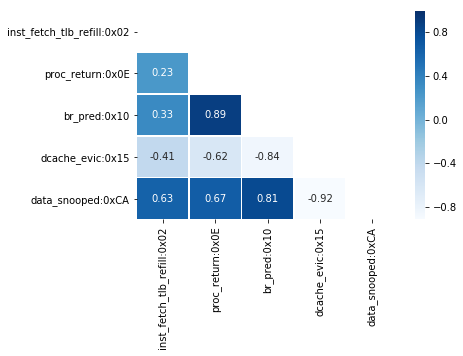

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv","speedup4b",0)

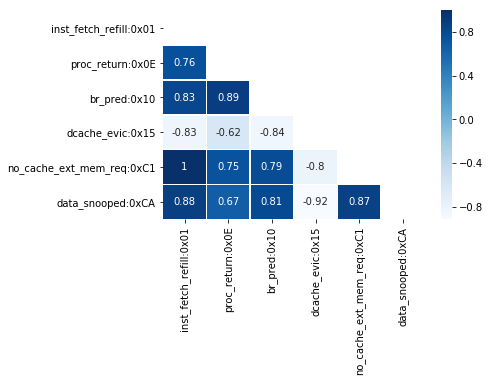

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv","speedup4b4l",0)

There is a lot of correlation between some variables. Using a hierarchical cluster we can better visualize how each feature relates to all the others.

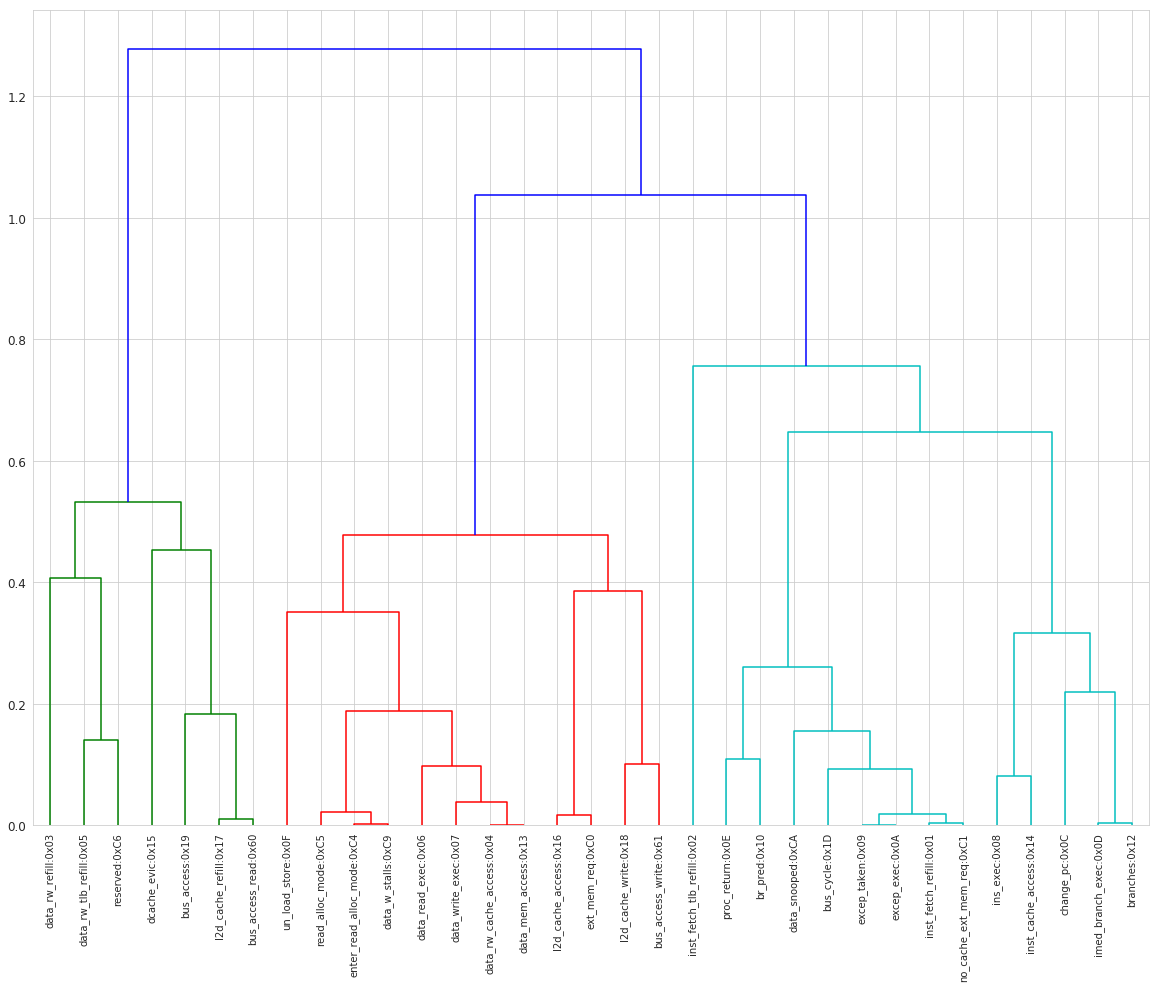

In [0]:
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import pdist

df = pd.read_csv("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv")

cluster_df = df.iloc[:,0:33]
corr = 1 - cluster_df.corr()

corr_condensed = shc.distance.squareform(corr) # convert to condensed
z = shc.linkage(corr_condensed, method='average')
dendrogram = shc.dendrogram(z, labels=corr.columns,leaf_font_size=10,leaf_rotation=90.)
plt.show()


### Analysing 4b

Now analysing 4b when the target is 4l.

In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv","speedup4l")

('L1D_CACHE_INVAL:0x48', 0.9532658423680135)
('L1D_CACHE_WB_CLEAN:0x47', 0.9325888251350072)
('STREX_FAIL_SPEC:0x6E', 0.9083742345540733)
('LDREX_SPEC:0x6C', 0.8346948257743523)
('DP_SPEC:0x73', 0.7585842772126771)
('L2D_CACHE_ST:0x51', 0.7532827296548391)
('L2D_CACHE_ACCESS:0x16', 0.7268047788470539)
('DMB_SPEC:0x7E', 0.7033949093297838)
('L1I_CACHE_REFILL:0x01', 0.6696358346118138)
('VFP_SPEC:0x75', 0.6513825168112081)
('L1D_CACHE_WB_VICTIM:0x46', 0.6499734994850521)
('L1D_CACHE_REFILL_LD:0x42', 0.648312247809884)
('L2D_CACHE_LD:0x50', 0.6413162220722738)
('LDST_SPEC:0x72', 0.6402029737447454)
('ST_SPEC:0x70', 0.638288132020269)
('MEM_ACCESS:0x13', 0.6334752174218512)
('L1D_CACHE_ACCESS:0x04', 0.6316883490313971)
('L1D_CACHE_ST:0x41', 0.6203274374566363)
('L1D_CACHE_REFILL_ST:0x43', 0.6168928525513151)
('MEM_ACCESS_ST:0X67', 0.6162560991355825)


When the target is 4b4l.

In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv","speedup4b4l")

('L1D_CACHE_WB_CLEAN:0x47', 0.933712212594947)
('UNALIGNED_ST_SPEC:0x69', 0.9053099109692837)
('L1D_CACHE_INVAL:0x48', 0.8950176764323065)
('LDREX_SPEC:0x6C', 0.8842152593721541)
('DMB_SPEC:0x7E', 0.8352171633100274)
('L1D_CACHE_REFILL_ST:0x43', 0.8346401444772109)
('L1I_CACHE_REFILL:0x01', 0.834324126158118)
('VFP_SPEC:0x75', 0.82121336825958)
('STREX_PASS_SPEC:0x6D', 0.7320561881094954)
('STREX_FAIL_SPEC:0x6E', 0.7275787374420628)
('L2D_CACHE_LD:0x50', 0.70282387179968)
('L1D_CACHE_REFILL_LD:0x42', 0.6910819450387182)
('L2D_CACHE_ACCESS:0x16', 0.6456590622365941)
('L1D_CACHE_REFILL:0x03', 0.6296773801767146)
('UNALIGNED_LDST_SPEC:0x6A', 0.6181728298990177)
('BUS_CYCLES:0x1D', 0.6075166841238759)
('EXC_TAKEN:0x09', 0.6015730895929923)


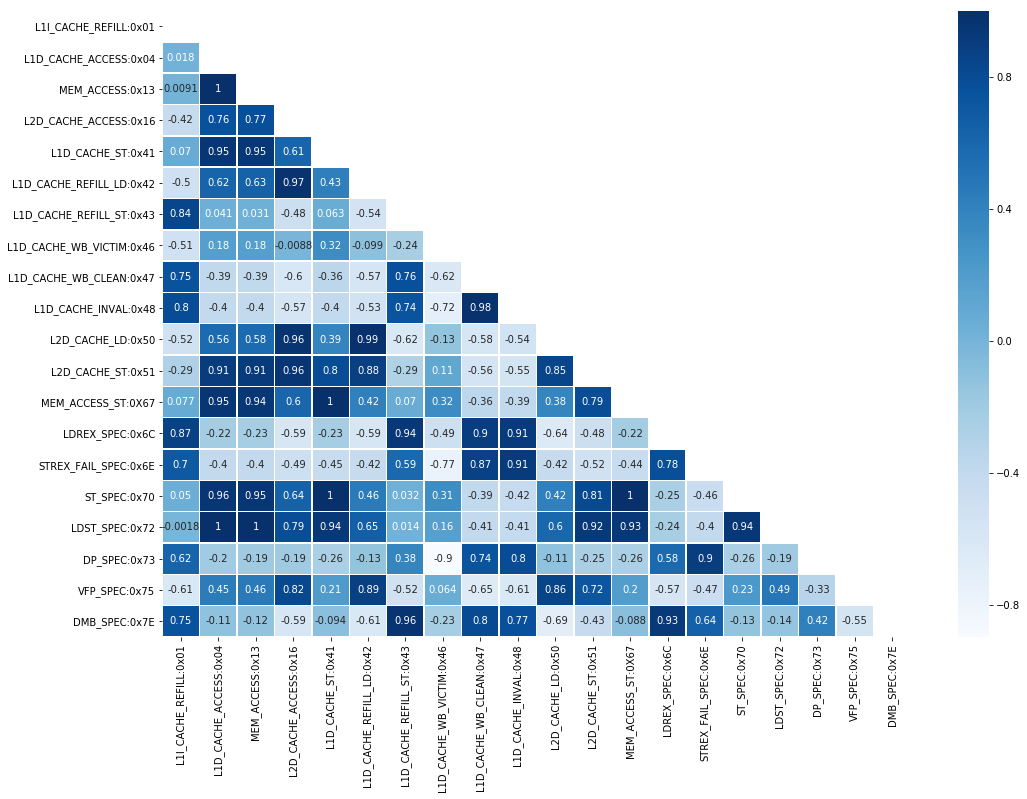

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv","speedup4l",2)

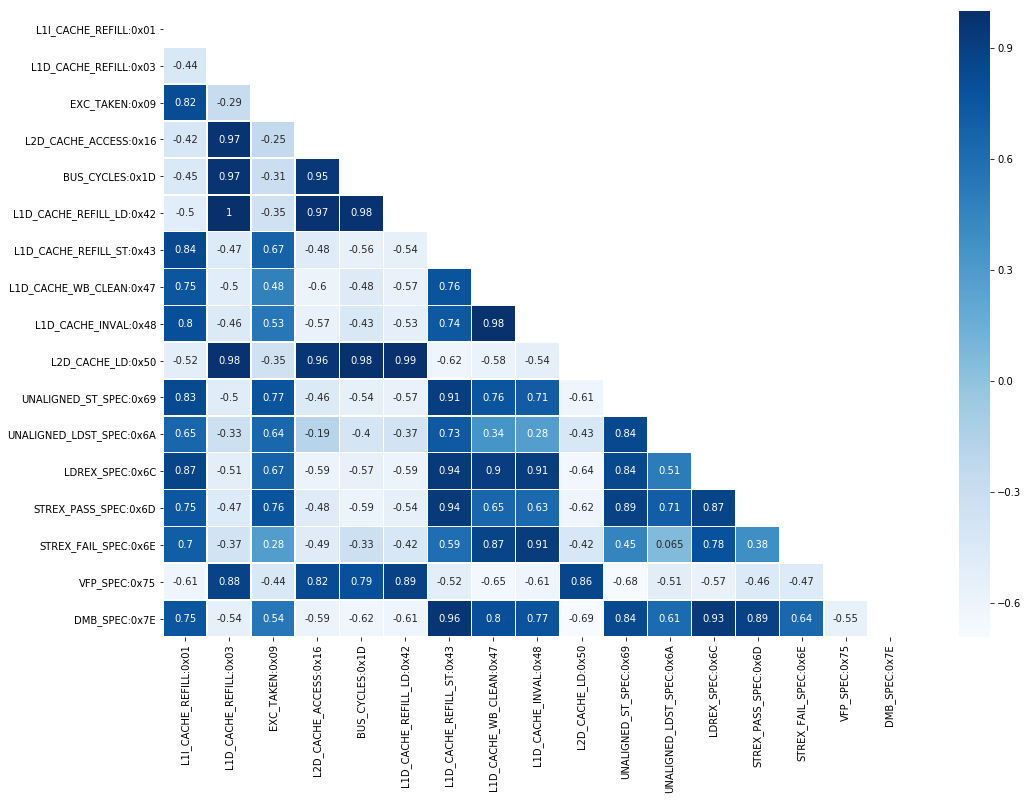

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv","speedup4b4l",1)

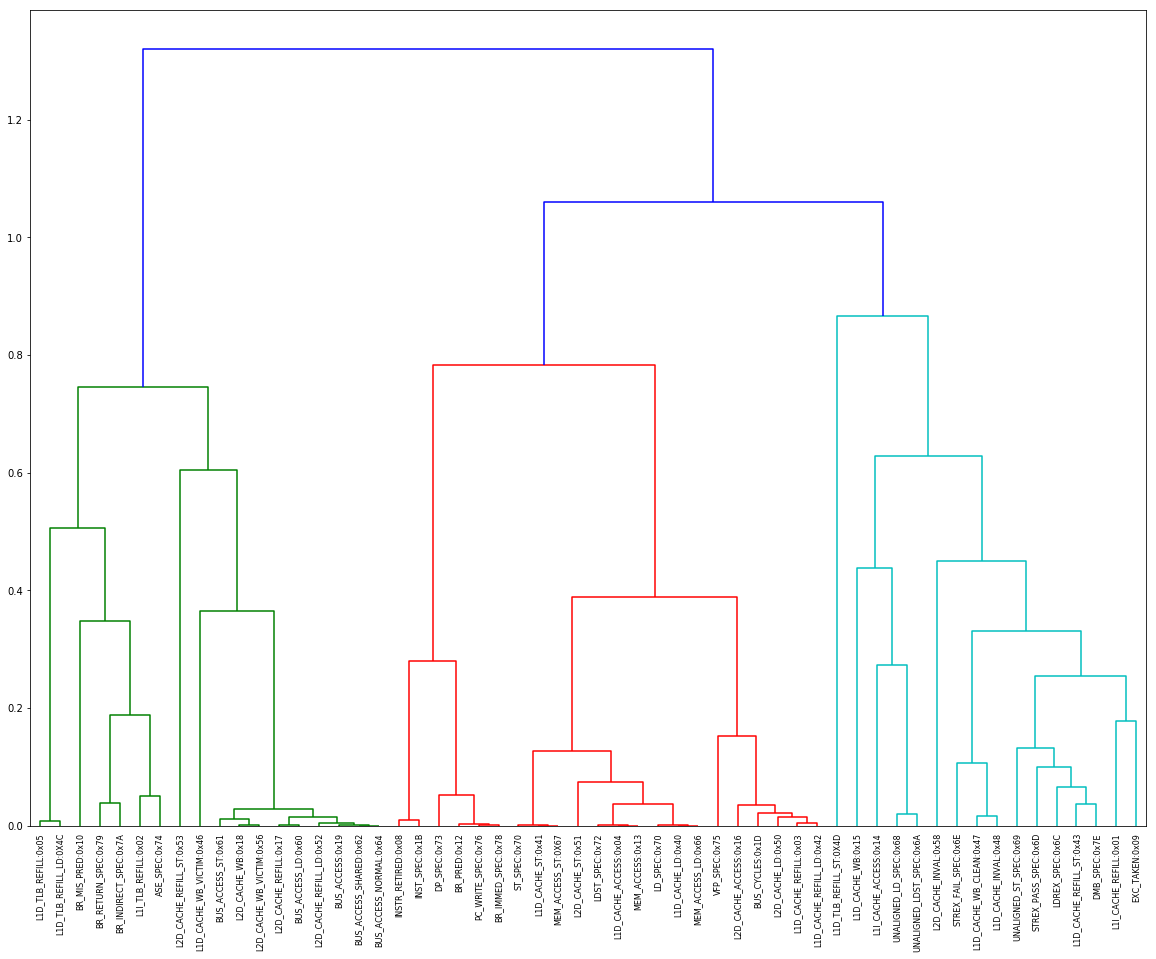

In [0]:
df = pd.read_csv("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv")

cluster_df = df.iloc[:,0:56]
corr = 1 - cluster_df.corr()

corr_condensed = shc.distance.squareform(corr) # convert to condensed
z = shc.linkage(corr_condensed, method='average')
dendrogram = shc.dendrogram(z, labels=corr.columns,leaf_font_size=8,leaf_rotation=90.)
plt.show()

### Analysing 4b4l

Now analysing 4b4l when the target is 4l.

In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv","speedup4l")

('dcache_evic:0x15', 0.8895561898738409)
('L1D_CACHE_INVAL:0x48', 0.8607817775791861)
('l2d_cache_access:0x16', 0.8565286652171049)
('ext_mem_req:0xC0', 0.8056062693926975)
('data_rw_cache_access:0x04', 0.7915867378181719)
('data_mem_access:0x13', 0.7864862563177162)
('STREX_FAIL_SPEC:0x6E', 0.7845775615745347)
('L1D_CACHE_WB_VICTIM:0x46', 0.768106585061643)
('data_read_exec:0x06', 0.7606190651992395)
('L1D_CACHE_WB_CLEAN:0x47', 0.7493780634152221)
('data_write_exec:0x07', 0.7116530537080373)
('bus_cycle:0x1D', 0.6998976249482958)
('L2D_CACHE_ACCESS:0x16', 0.6839794542176838)
('L2D_CACHE_LD:0x50', 0.6803189794080163)
('L2D_CACHE_ST:0x51', 0.6782883765229107)
('L1D_CACHE_ST:0x41', 0.6719314301671623)
('data_rw_refill:0x03', 0.6691764099107473)
('MEM_ACCESS_ST:0X67', 0.6620003008777795)
('ST_SPEC:0x70', 0.6616670706649886)
('L1D_CACHE_WB:0x15', 0.6531629608763706)
('VFP_SPEC:0x75', 0.6450467527132794)
('L2D_CACHE_INVAL:0x58', 0.6124615514638706)
('L1D_CACHE_REFILL:0x03', 0.61124994877047

When the target is 4b4l.

In [0]:
show_relevant_pmc("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv","speedup4b")

('L1D_CACHE_INVAL:0x48', 0.973687611546484)
('dcache_evic:0x15', 0.9198298652797774)
('STREX_FAIL_SPEC:0x6E', 0.9025204168756904)
('L1D_CACHE_WB_CLEAN:0x47', 0.8507658788044985)
('l2d_cache_access:0x16', 0.8310748152504056)
('L1D_CACHE_WB_VICTIM:0x46', 0.7998238257192293)
('ext_mem_req:0xC0', 0.7881299183544284)
('L2D_CACHE_INVAL:0x58', 0.7392618081272899)
('data_read_exec:0x06', 0.7375529886338754)
('data_rw_refill:0x03', 0.7272821385962965)
('L2D_CACHE_LD:0x50', 0.726509781129427)
('VFP_SPEC:0x75', 0.7207943798832717)
('data_rw_cache_access:0x04', 0.7090884482695677)
('L2D_CACHE_ACCESS:0x16', 0.7058374329000644)
('data_mem_access:0x13', 0.6919020050180651)
('L2D_CACHE_ST:0x51', 0.6796740253907027)
('EXC_TAKEN:0x09', 0.6547541035955418)
('L2D_CACHE_WB_VICTIM:0x56', 0.6399262305678817)
('L1D_CACHE_REFILL:0x03', 0.6391461566949755)
('L1I_CACHE_REFILL:0x01', 0.6370595656892791)
('L1D_CACHE_REFILL_LD:0x42', 0.636361854722077)
('L2D_CACHE_WB:0x18', 0.6225592258028189)
('DP_SPEC:0x73', 0.61

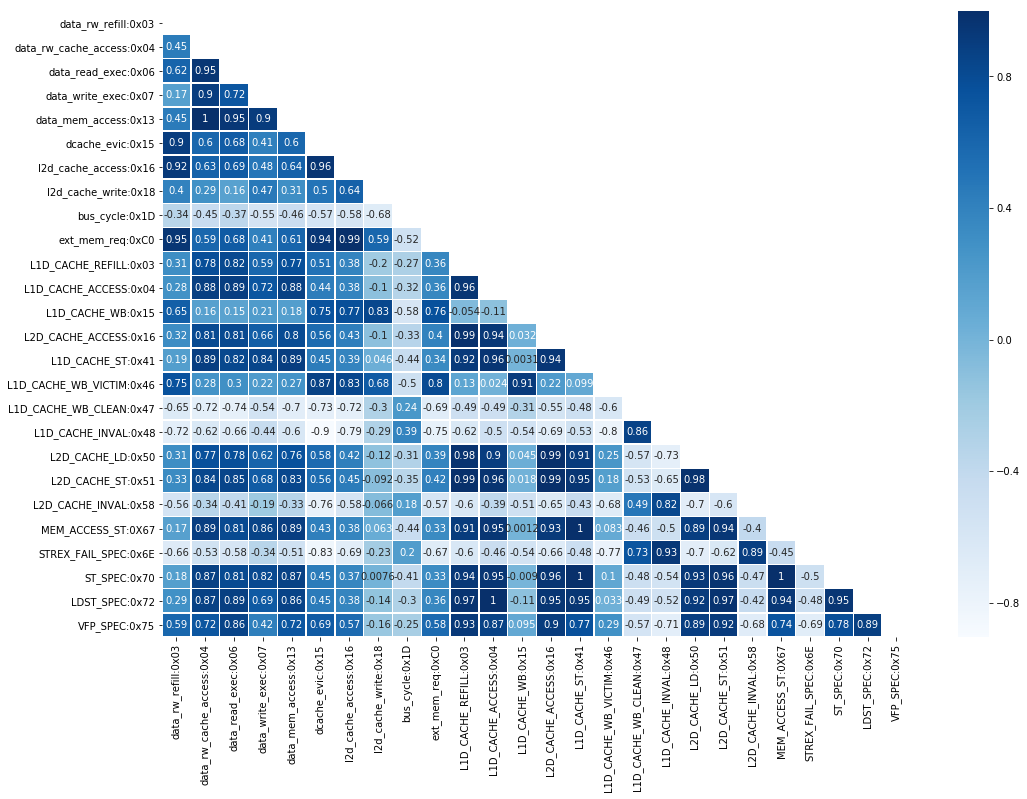

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv","speedup4l",2)

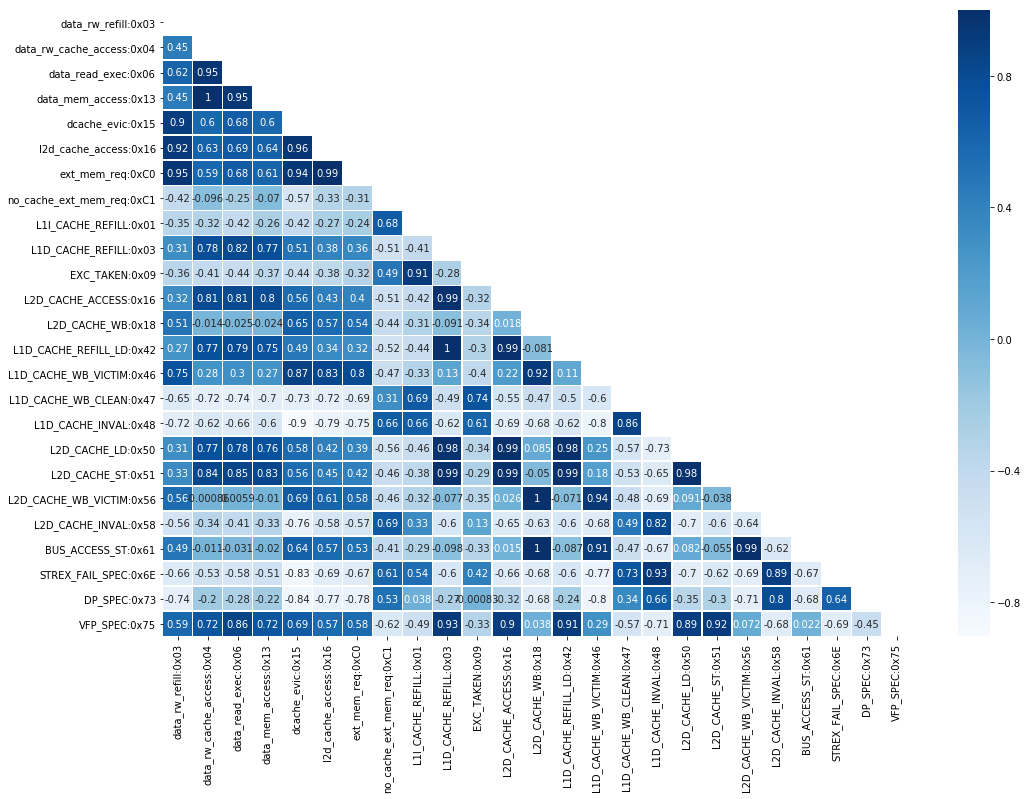

In [0]:
plot_correlation_between_selected_features("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv","speedup4b",2)

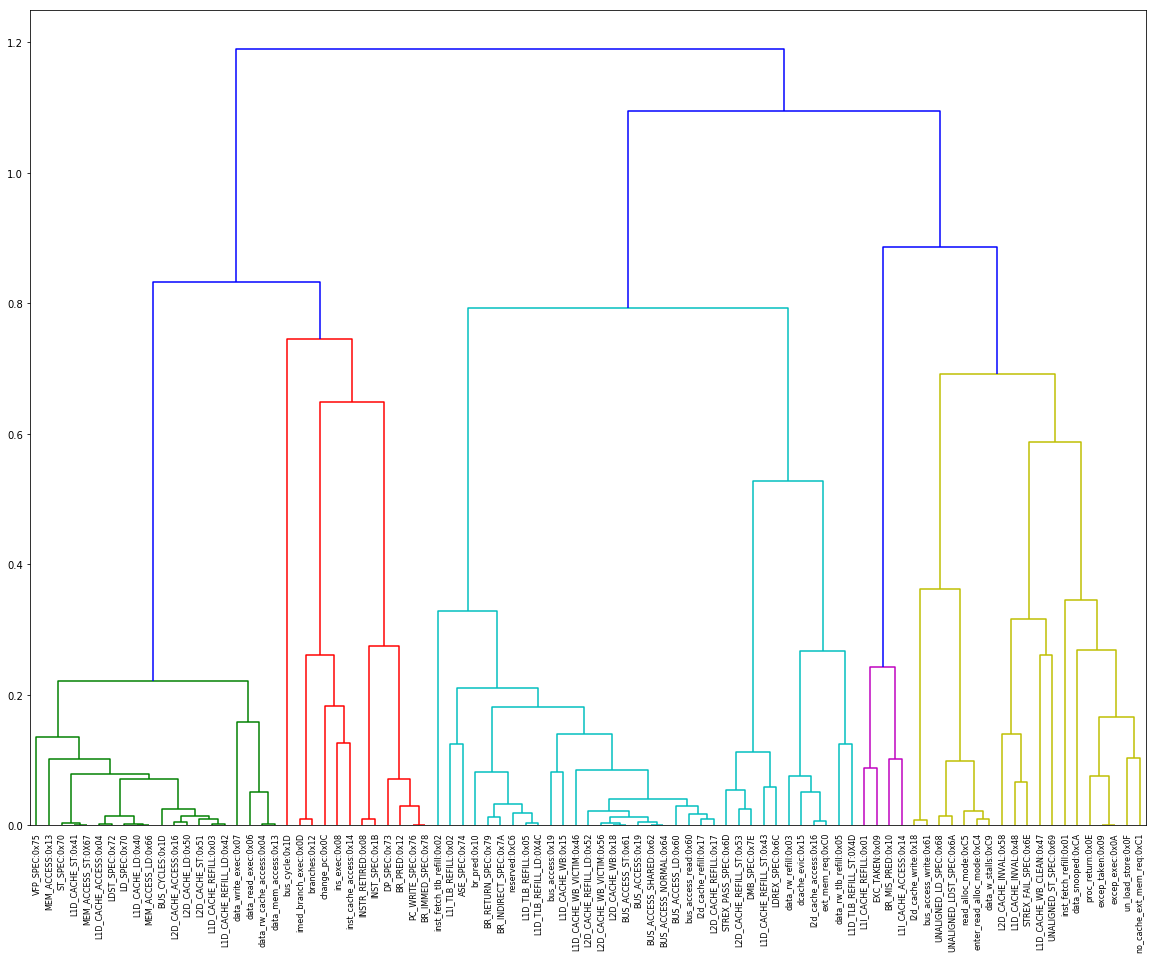

In [0]:
df = pd.read_csv("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv")

cluster_df = df.iloc[:,0:89]
corr = 1 - cluster_df.corr()

corr_condensed = shc.distance.squareform(corr) # convert to condensed
z = shc.linkage(corr_condensed, method='average')
dendrogram = shc.dendrogram(z, labels=corr.columns,leaf_font_size=8,leaf_rotation=90.)
plt.show()

# Wrapper

Wrapper-based methods use models to decide which pmcs to select.

In [0]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def wrapper_method(file_path,threshold_config):
    
  df = pd.read_csv(file_path)
  df_X = df.iloc[:, 0:(len(df.columns) - 3)]
  df_Y = df.iloc[:, len(df.columns) - 3: len(df.columns)]  
  
  X = df_X.values 
  Y = df_Y.values
  
  regr_rf = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
  regr_rf.fit(X, Y)
  y_rf = regr_rf.predict(X)
  r2_before = float("{0:.2f}".format(r2_score(Y, y_rf)))

  #Mapping each importance value to feature and after sort.
  result=[]
  for feature in zip(df.columns, regr_rf.feature_importances_):
      result.append(tuple(feature))

  order_list = sorted(result,key=operator.itemgetter(1), reverse=True)
  if(len(order_list) > 50):#remove features over 50, because the size plot
     order_list = order_list[:len(order_list)-(len(order_list)-50)]


  #Convert dictionary to dataframe
  df_order_list = pd.DataFrame(order_list)     
  feat_imp = regr_rf.feature_importances_ 
  if threshold_config == 0:
    cols = df_X.columns[feat_imp >= 0.061]
  elif threshold_config == 1:
    cols = df_X.columns[feat_imp >= 0.043]
  else:
    cols = df_X.columns[feat_imp >= 0.021]

  #Evaluate the model now only with the selected fetures.
  est_imp = RandomForestRegressor(n_estimators=100, max_depth=30,random_state=2)
  est_imp.fit(df_X[cols].values, df_Y.values)
  y_rf = est_imp.predict(df_X[cols].values)
  r2_after = float("{0:.2f}".format(r2_score(df_Y.values, y_rf)))
  
  #Graph
  font = {'family' : 'sans-serif', 'size': 12}
  plt.rc('font', **font)

  title_string = "Random Forest - Feature Importance" + "\n All Select Columns(Total=" + str(len(df_X.columns)) + "), R² =" + str(r2_before) +  "\n Nº Select Columns = " + str(len(cols)) + ", R²= " + str(r2_after)
  plt.figure(figsize=(25, 15))
  sns.set_style("whitegrid")
  ax = sns.barplot(df_order_list[1],df_order_list[0], palette="Blues_d")

  ax.set_title(title_string,fontsize= 20) 
  ax.set_xlabel('Importance',fontsize = 20) 
  ax.set_ylabel('Counters', fontsize = 20)
  
  plt.show()

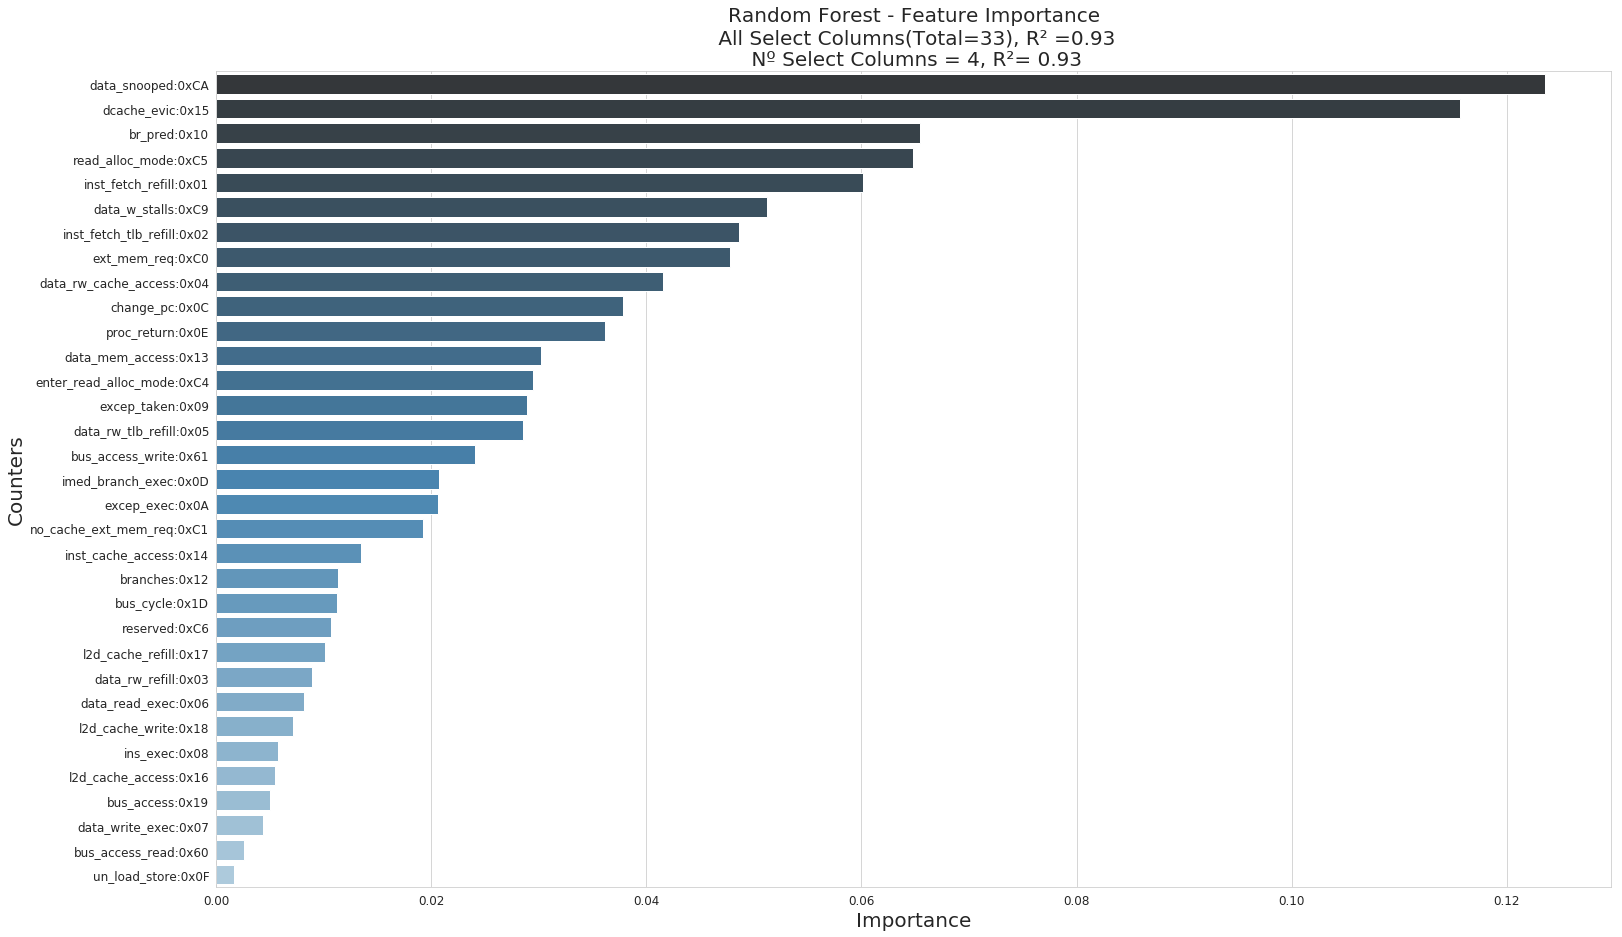

In [0]:
wrapper_method("/mntDrive/My Drive/Doutorado/Feature Selection/data/4l.csv",0)

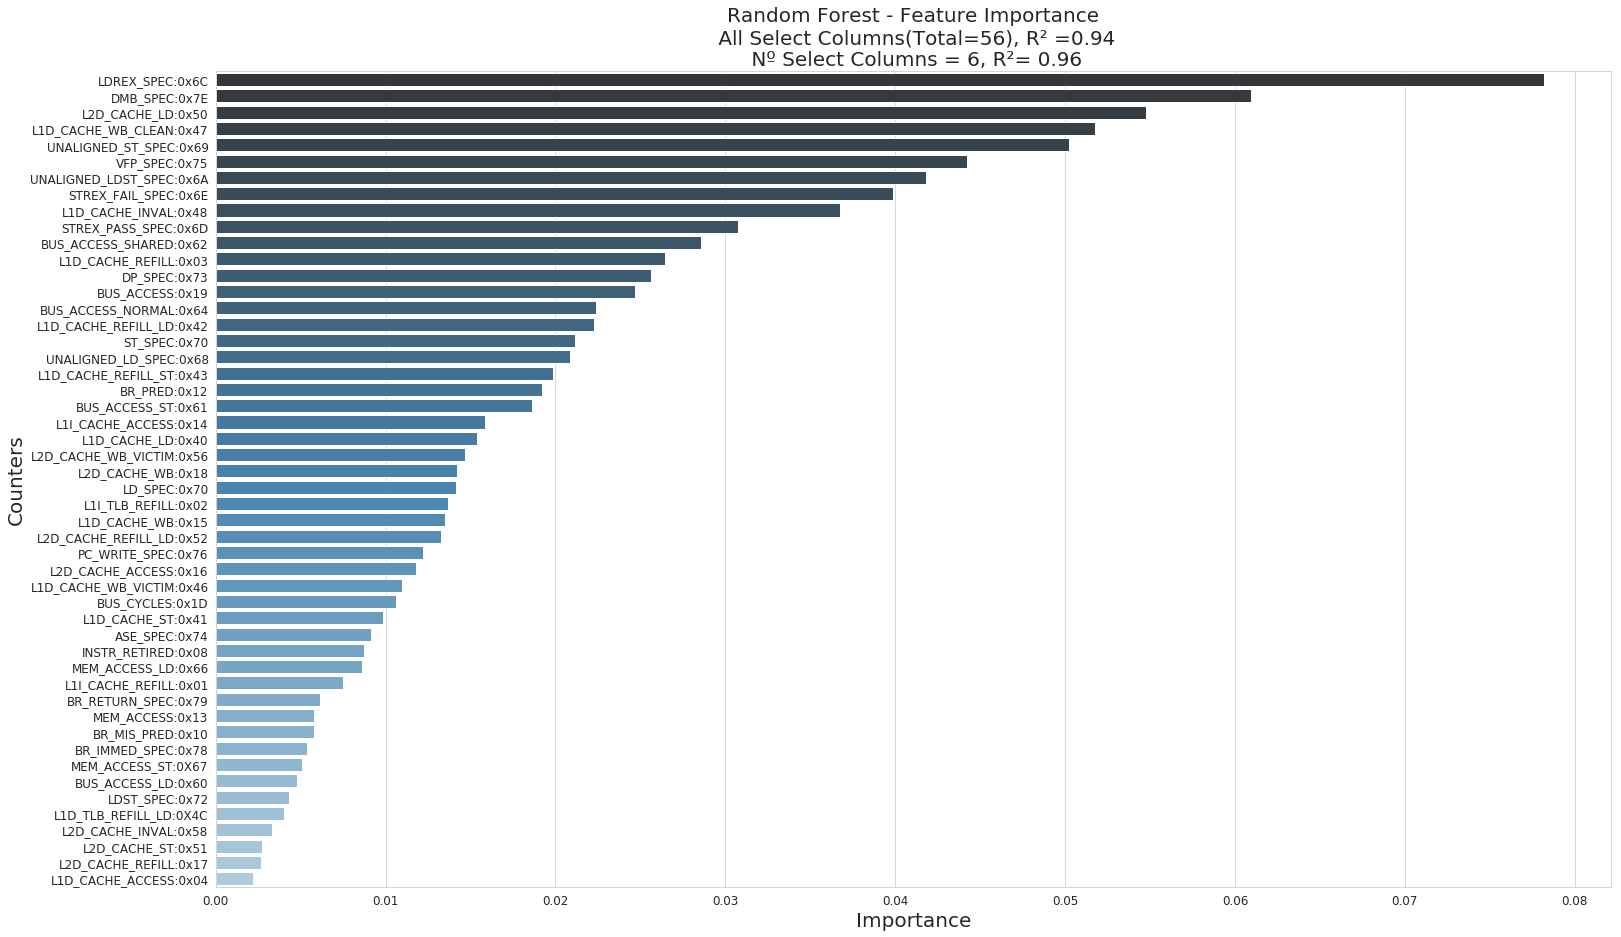

In [0]:
wrapper_method("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b.csv",1)

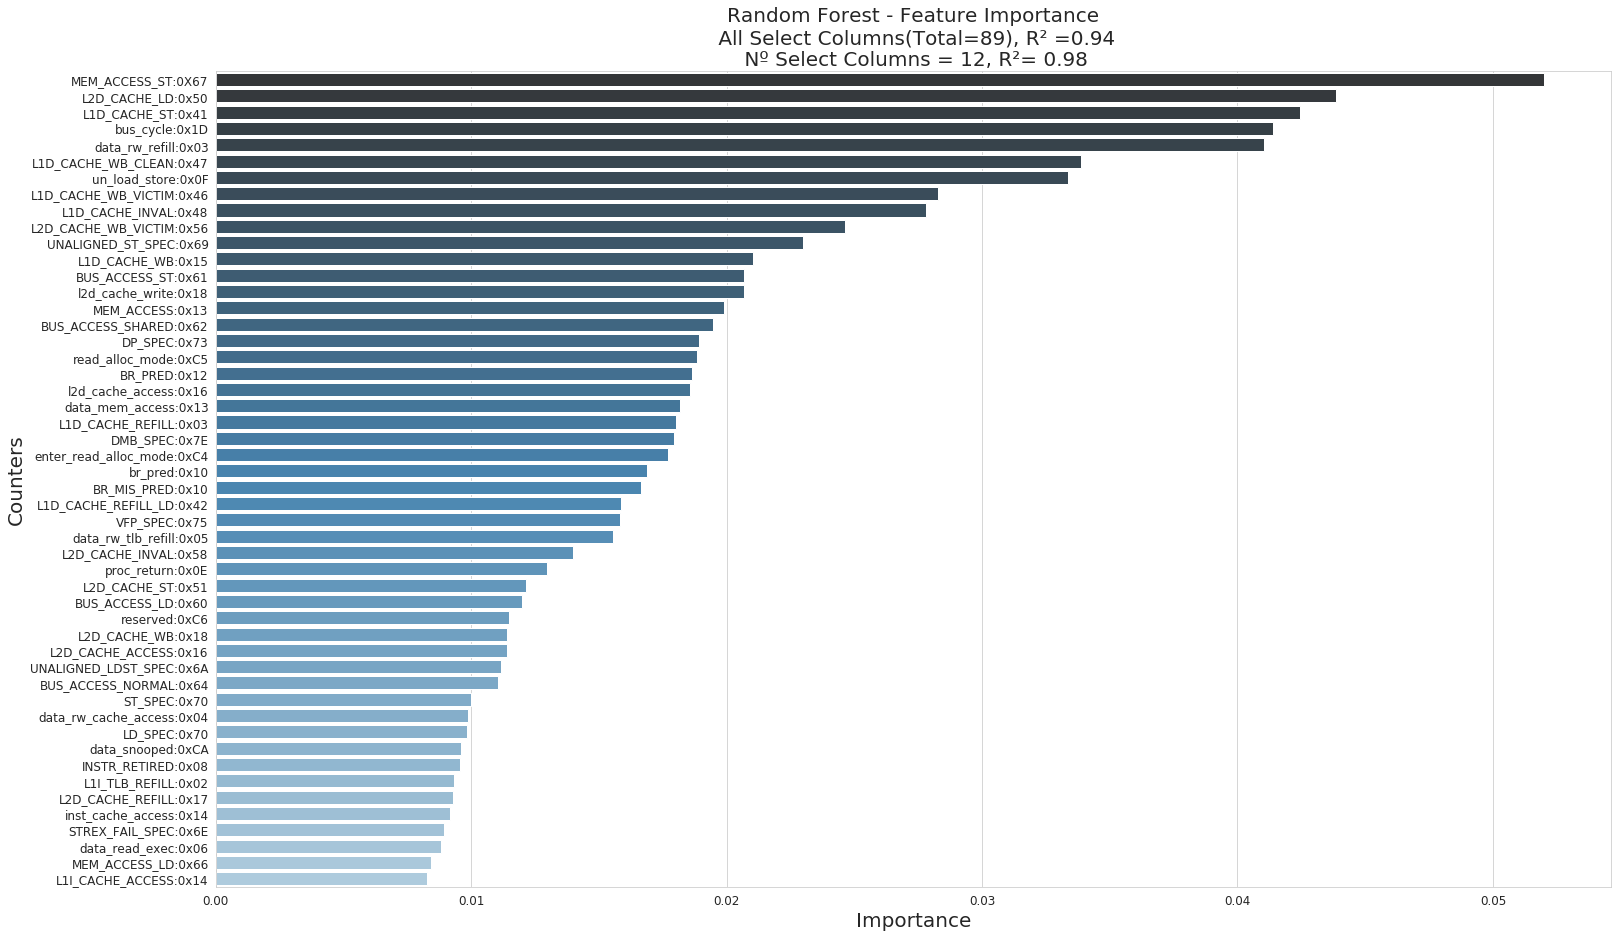

In [0]:
wrapper_method("/mntDrive/My Drive/Doutorado/Feature Selection/data/4b4l.csv",2)